## CS441: Applied ML - HW 2

### Parts 1-2: MNIST

Include all the code for generating MNIST results below

In [83]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression


def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

### Part 1: PCA and Data Compression

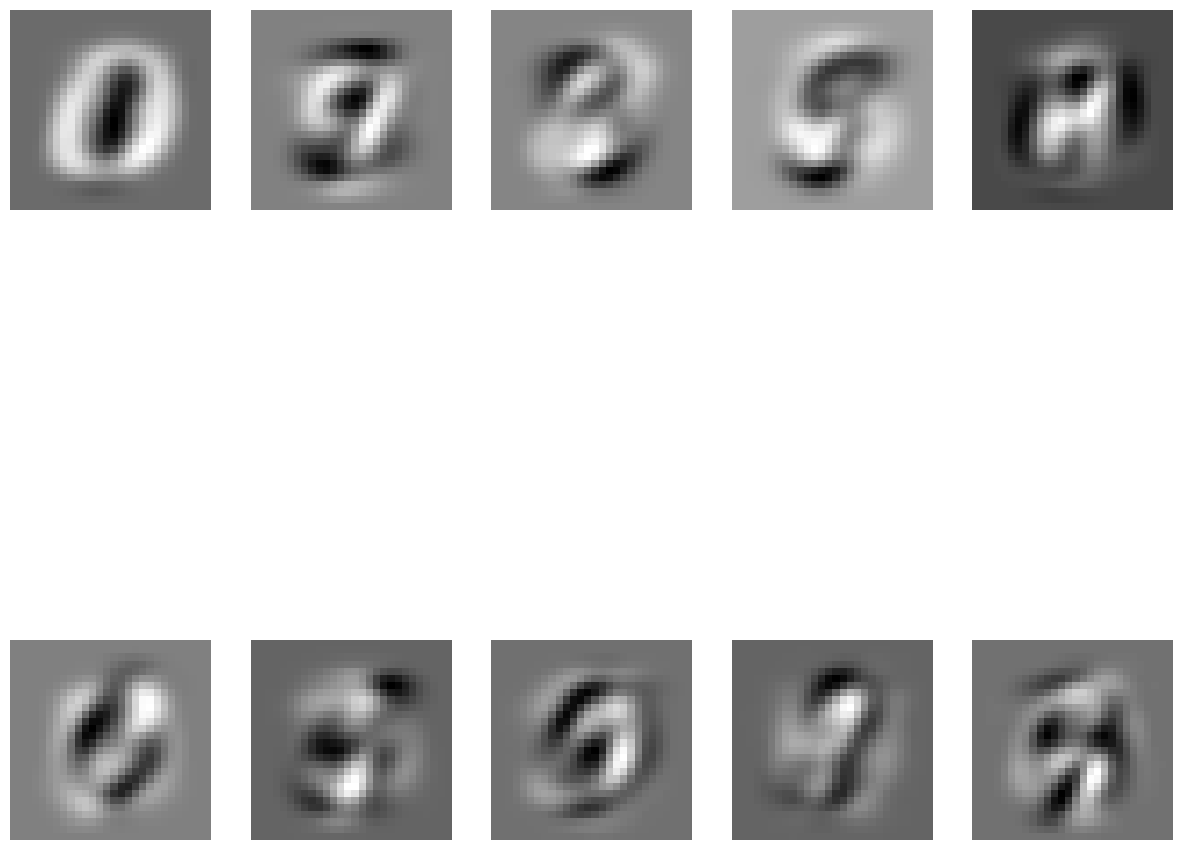

In [84]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_mnist()

# Modified display_mnist func
def display_mnist(x, subplot_rows=1, subplot_cols=1):
    '''
    Displays one or more examples in a row or a grid
    '''
    if subplot_rows > 1 or subplot_cols > 1 or len(x) > 1:
        fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
        for i in range(len(x)):
            if subplot_rows > 1 or subplot_cols > 1:
                ax.ravel()[i].imshow(x[i], cmap='gray')
                ax.ravel()[i].axis('off')
            else:
                plt.imshow(x[i], cmap='gray')
                plt.axis('off')
    else:
        plt.imshow(x[0], cmap='gray')
        plt.axis('off')
    plt.show()


# Compute the first 10 principal components using x_train

# TO DO

# Display First 10 Components

pca = PCA(n_components=10)
pca.fit(x_train)

# Retrieve the principal components and transform them back to 28x28 format for visualization
components = pca.components_
images = np.reshape(components, (10, 28, 28))  # Reshape components to 28x28 images

# Display the first 10 components in a 2x5 grid
display_mnist(images, subplot_rows=2, subplot_cols=5)





In [1]:
# Scatter plot of first two PCA dimensions
import seaborn as sns

(x_train, y_train), (x_test, y_test) = load_mnist()

pca = PCA(n_components=10)
x_pca = pca.fit_transform(x_train[:500])

# use pca.transform
# TO DO
ind = np.arange(500)
sns.scatterplot(x=x_pca[ind,0],y=x_pca[ind,1], hue=y_train[ind], palette="colorblind")

NameError: name 'load_mnist' is not defined

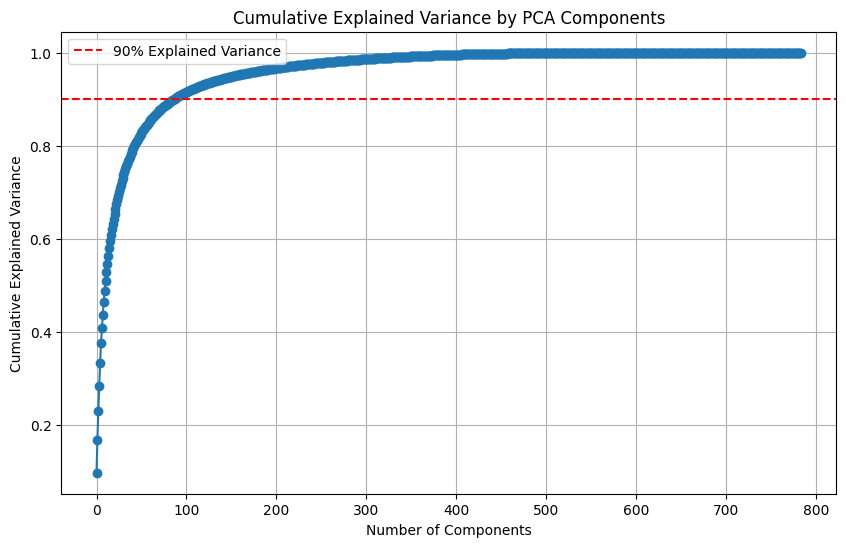

In [34]:
# Plot cumulative explained variance ratio
# cumsum and pca.explained_variance_ratio_ will be useful
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# TO DO
(x_train, y_train), (x_test, y_test) = load_mnist()

pca = PCA()
pca.fit(x_train)

cum_var = np.cumsum(pca.explained_variance_ratio_)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cum_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.legend(loc='best')

plt.show()




In [51]:
# Select number of dimensions that explains 90% of variance, according to your plot above
from sklearn.decomposition import PCA
import numpy as np
import faiss
import time
from sklearn.metrics import accuracy_score

pca_87 = PCA(n_components=87)
pca_87.fit(x_train)
x_train_pca = pca_87.transform(x_train)
x_test_pca = pca_87.transform(x_test)

# Convert data type for Faiss compatibility
x_train_faiss = x_train.astype('float32')
x_test_faiss = x_test.astype('float32')
x_train_pca_faiss = x_train_pca.astype('float32')
x_test_pca_faiss = x_test_pca.astype('float32')

# Create a Faiss index (L2 distance) for original features
index_original = faiss.IndexFlatL2(x_train_faiss.shape[1])
index_original.add(x_train_faiss)  # add the vectors to the index

# Create a Faiss index for compressed features
index_compressed = faiss.IndexFlatL2(x_train_pca_faiss.shape[1])
index_compressed.add(x_train_pca_faiss)


# Function to perform 1-NN search and calculate accuracy
def perform_search(index, x_query, y_true):
    start_time = time.time()
    _, I = index.search(x_query, k=1)  # Perform 1-NN search
    end_time = time.time()
    y_pred = y_train[I.flatten()]  # Retrieve predictions
    accuracy = accuracy_score(y_true, y_pred)

    total_time = end_time - start_time
    error = 1 - accuracy

    return total_time, error  

# Compute time and error for 1-NN with original features
time_original, error_original = perform_search(index_original, x_test_faiss, y_test)

# Compute time and error for 1-NN with compressed features
time_compressed, error_compressed = perform_search(index_compressed, x_test_pca_faiss, y_test)

print(f"Original Features Time: {time_original:.2f} s, Error: {error_original:.4f}")
print(f"Compressed Features Time: {time_compressed:.2f} s, Error: {error_compressed:.4f}")




Original Features Time: 0.82 s, Error: 0.0309
Compressed Features Time: 0.38 s, Error: 0.0270


### Part 2: MNIST Classification with Linear Models

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

LLR/SVM vs training size

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import numpy as np

nsample = [100, 1000, 10000, 60000]
results = []

for N in nsample:
    x_train_N = x_train[:N]
    y_train_N = y_train[:N]
    
    # Train Logistic Regression
    lr = LogisticRegression(max_iter=10000)
    lr.fit(x_train_N, y_train_N)
    y_pred_lr = lr.predict(x_test)
    error_lr = 1 - accuracy_score(y_test, y_pred_lr)
    
    # Train Linear SVM
    svm = LinearSVC(max_iter=10000)
    svm.fit(x_train_N, y_train_N)
    y_pred_svm = svm.predict(x_test)
    error_svm = 1 - accuracy_score(y_test, y_pred_svm)
    
    # Store the results
    results.append({
        'Training Size': N,
        'LR Error': error_lr,
        'SVM Error': error_svm
    })

# Display the results
for result in results:
    print(f"Training Size: {result['Training Size']}, LR Error: {result['LR Error']:.4f}, SVM Error: {result['SVM Error']:.4f}")


/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Size: 100, LR Error: 0.3250, SVM Error: 0.3236
Training Size: 1000, LR Error: 0.1378, SVM Error: 0.1611
Training Size: 10000, LR Error: 0.0950, SVM Error: 0.1112
Training Size: 60000, LR Error: 0.0744, SVM Error: 0.0817


Error visualization

/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LR: Most confidently correct for label 0:


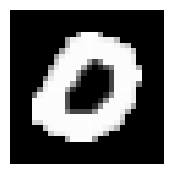

LR: Most confidently incorrect for label 0:


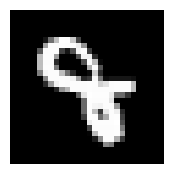

SVM: Most confidently correct for label 0:


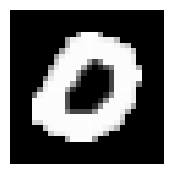

SVM: Most confidently incorrect for label 0:


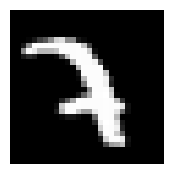

LR: Most confidently correct for label 1:


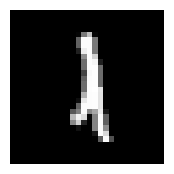

LR: Most confidently incorrect for label 1:


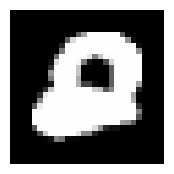

SVM: Most confidently correct for label 1:


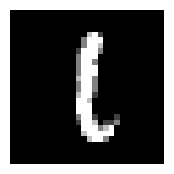

SVM: Most confidently incorrect for label 1:


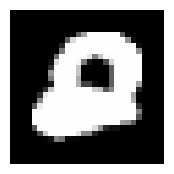

LR: Most confidently correct for label 2:


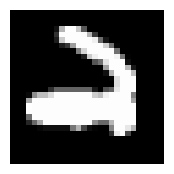

LR: Most confidently incorrect for label 2:


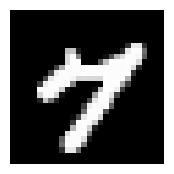

SVM: Most confidently correct for label 2:


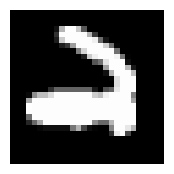

SVM: Most confidently incorrect for label 2:


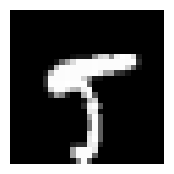

LR: Most confidently correct for label 3:


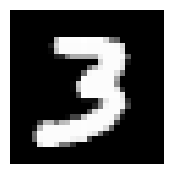

LR: Most confidently incorrect for label 3:


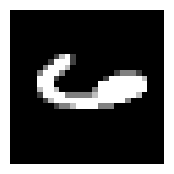

SVM: Most confidently correct for label 3:


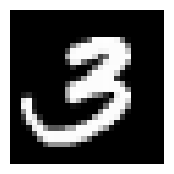

SVM: Most confidently incorrect for label 3:


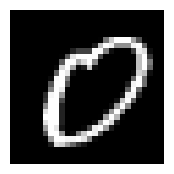

LR: Most confidently correct for label 4:


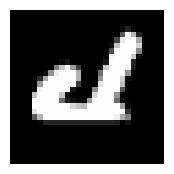

LR: Most confidently incorrect for label 4:


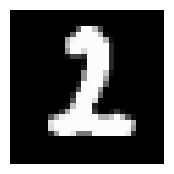

SVM: Most confidently correct for label 4:


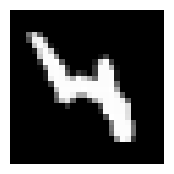

SVM: Most confidently incorrect for label 4:


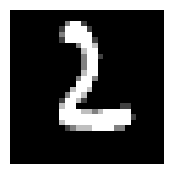

LR: Most confidently correct for label 5:


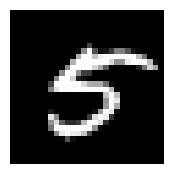

LR: Most confidently incorrect for label 5:


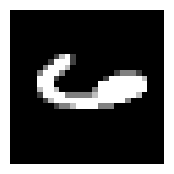

SVM: Most confidently correct for label 5:


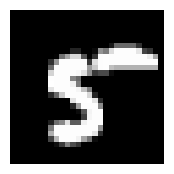

SVM: Most confidently incorrect for label 5:


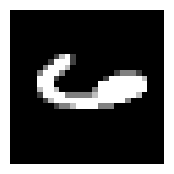

LR: Most confidently correct for label 6:


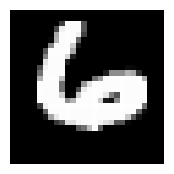

LR: Most confidently incorrect for label 6:


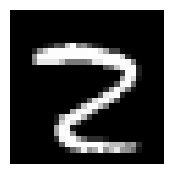

SVM: Most confidently correct for label 6:


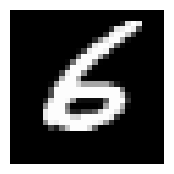

SVM: Most confidently incorrect for label 6:


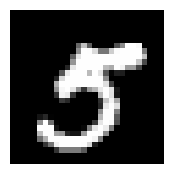

LR: Most confidently correct for label 7:


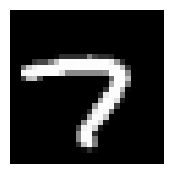

LR: Most confidently incorrect for label 7:


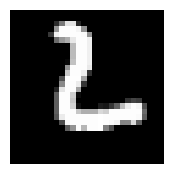

SVM: Most confidently correct for label 7:


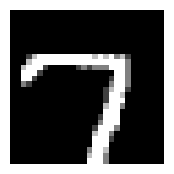

SVM: Most confidently incorrect for label 7:


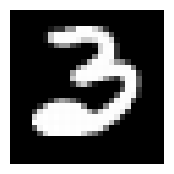

LR: Most confidently correct for label 8:


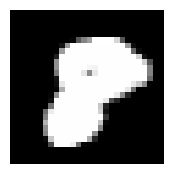

LR: Most confidently incorrect for label 8:


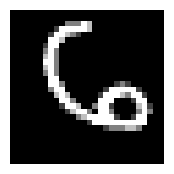

SVM: Most confidently correct for label 8:


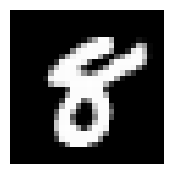

SVM: Most confidently incorrect for label 8:


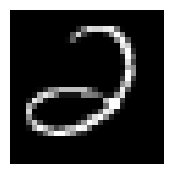

LR: Most confidently correct for label 9:


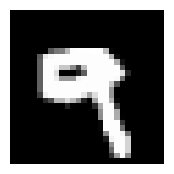

LR: Most confidently incorrect for label 9:


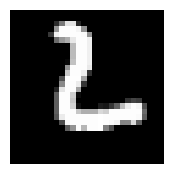

SVM: Most confidently correct for label 9:


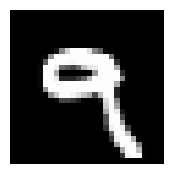

SVM: Most confidently incorrect for label 9:


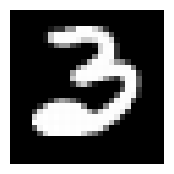

In [50]:
# to get scores for logistic regression use: scores = model_lr.predict_proba(x_test)
# TO DO

# to get scores for SVM use: scores = model_svm.decision_function(x_test)
# TO DO

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import label_binarize


    
# Train Logistic Regression
llr = LogisticRegression(max_iter=10000)
llr.fit(x_train, y_train)
y_pred_llr = lr.predict(x_test)
llr_score = llr.predict_proba(x_test)

# Train Linear SVM
svm = LinearSVC(max_iter=10000, C=1.5)
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)
svm_score = svm.decision_function(x_test)


# For Logistic Regression
scores_lr = llr.predict_proba(x_test)  
predictions_lr = np.argmax(scores_lr, axis=1)  
correctness_lr = predictions_lr == y_test 

# For Linear SVM
scores_svm = svm.decision_function(x_test)  
predictions_svm = np.argmax(scores_svm, axis=1)  
correctness_svm = predictions_svm == y_test 

def display_mnist(x, subplot_rows=1, subplot_cols=1, img_size = (2, 2)):
  '''
  Displays one or more examples in a row or a grid. Adjust figsize for smaller images.
  '''
  # Calculate figure size dynamically based on the number of columns; adjust width per image and height
  figure_width = subplot_cols * 2
  figure_height = subplot_rows * 2
  fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(figure_width, figure_height))
  
  if subplot_rows > 1 or subplot_cols > 1:
    for i in range(len(x)):
      ax.ravel()[i].imshow(x[i].reshape(28, 28), cmap='gray')  
      ax.ravel()[i].axis('off')
  else:
      plt.imshow(x[0].reshape(28, 28), cmap='gray')  
      plt.axis('off')
  plt.show()


for label in range(10):
    # Logistic Regression
    label_scores_lr = scores_lr[:, label] 
    correct_indices_lr = np.where((predictions_lr == label) & correctness_lr)[0]
    incorrect_indices_lr = np.where((predictions_lr != label) & ~correctness_lr)[0]  
    
    if len(correct_indices_lr) > 0:
        most_confident_correct_lr = correct_indices_lr[np.argmax(label_scores_lr[correct_indices_lr])]
        print(f"LR: Most confidently correct for label {label}:")
        display_mnist(x_test[most_confident_correct_lr].reshape(1, 28, 28),img_size=(1, 1))
    
    if len(incorrect_indices_lr) > 0:
        most_confident_incorrect_lr = incorrect_indices_lr[np.argmin(label_scores_lr[incorrect_indices_lr])]
        print(f"LR: Most confidently incorrect for label {label}:")
        display_mnist(x_test[most_confident_incorrect_lr].reshape(1, 28, 28), img_size=(1, 1))  
    
    # SVM
    label_scores_svm = scores_svm[:, label]  
    correct_indices_svm = np.where((predictions_svm == label) & correctness_svm)[0]
    incorrect_indices_svm = np.where((predictions_svm != label) & ~correctness_svm)[0]  
    
    if len(correct_indices_svm) > 0:
        most_confident_correct_svm = correct_indices_svm[np.argmax(label_scores_svm[correct_indices_svm])]
        print(f"SVM: Most confidently correct for label {label}:")
        display_mnist(x_test[most_confident_correct_svm].reshape(1, 28, 28), img_size=(1, 1))
    
    if len(incorrect_indices_svm) > 0:
        most_confident_incorrect_svm = incorrect_indices_svm[np.argmin(label_scores_svm[incorrect_indices_svm])]
        print(f"SVM: Most confidently incorrect for label {label}:")
        display_mnist(x_test[most_confident_incorrect_svm].reshape(1, 28, 28), img_size=(1, 1))



    

Parameter selection

/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C=0.0078125, Validation Error: 0.1302
C=0.015625, Validation Error: 0.1245


/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C=0.0195325, Validation Error: 0.1235
C=0.025, Validation Error: 0.1253
C=0.03125, Validation Error: 0.1257
C=0.0625, Validation Error: 0.1287


/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C=0.125, Validation Error: 0.1344


/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C=0.25, Validation Error: 0.1398


/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C=0.5, Validation Error: 0.1453


/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C=1.0, Validation Error: 0.1498


/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C=2.0, Validation Error: 0.1530


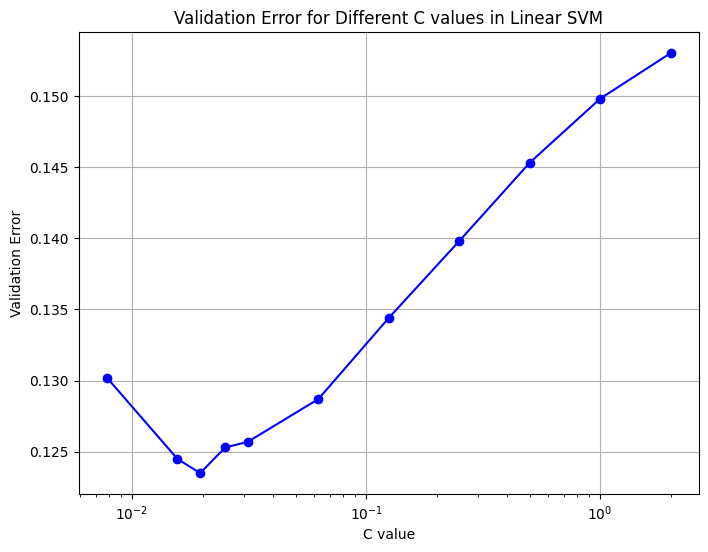

In [90]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train, y_train, and x_test, y_test are already loaded

# Split the data for this experiment
x_train_small = x_train[:1000]
y_train_small = y_train[:1000]
x_val = x_train[50000:]
y_val = y_train[50000:]

# Range of C values to test
C_values = [0.0078125,0.015625,0.0195325,0.025,0.03125,0.0625,0.125,0.25,0.5,1.0,2.0]
val_errors = []

# Iterate over the range of C values
for C in C_values:
    # Train Linear SVM
    svm = LinearSVC(C=C, max_iter=10000)
    svm.fit(x_train_small, y_train_small)
    
    # Evaluate on the validation set
    y_pred_val = svm.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_error = 1 - val_accuracy
    val_errors.append(val_error)
    
    print(f"C={C}, Validation Error: {val_error:.4f}")

# Find the best C value and its corresponding validation error
best_index = np.argmin(val_errors)
best_C = C_values[best_index]
best_error = val_errors[best_index]

# Plotting the validation error for each C value
plt.figure(figsize=(8, 6))
plt.semilogx(C_values, val_errors, marker='o', linestyle='-', color='b')
plt.xlabel('C value')
plt.ylabel('Validation Error')
plt.title('Validation Error for Different C values in Linear SVM')
plt.grid(True)
plt.show()


In [89]:
# Get test result for selected parameter

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# TO DO

x_train_compressed = x_train[:1000]
y_train_compressed = y_train[:1000]
x_val = x_train[50000:]
y_val = y_train[50000:]

best_C = 0.025

# Train a new model with the best C value on the larger initial training set
lr_best = LogisticRegression(C=best_C, max_iter=10000)
lr_best.fit(x_train_compressed, y_train_compressed)

# Evaluate on the test set
y_pred_test = lr_best.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_error = 1 - test_accuracy

print(f"Best C: {best_C}, Validation Error: {best_error:.4f}, Test Error: {test_error:.4f}")

Best C: 0.025, Validation Error: 0.1235, Test Error: 0.1465


## Part 3: Temperature Regression


In [156]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  
  datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW2/Code/temperature_data.npz"
  T = np.load(datadir)
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)
  

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()


Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


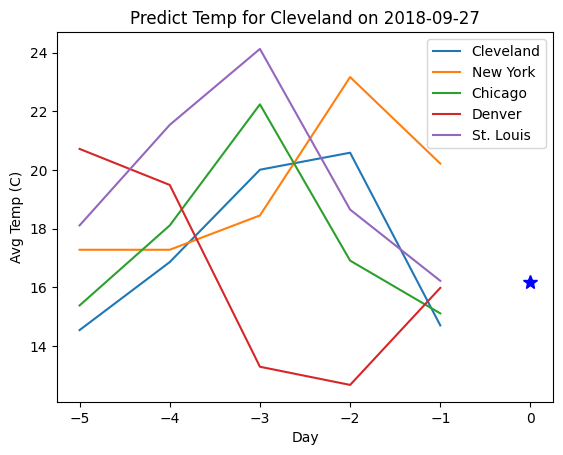

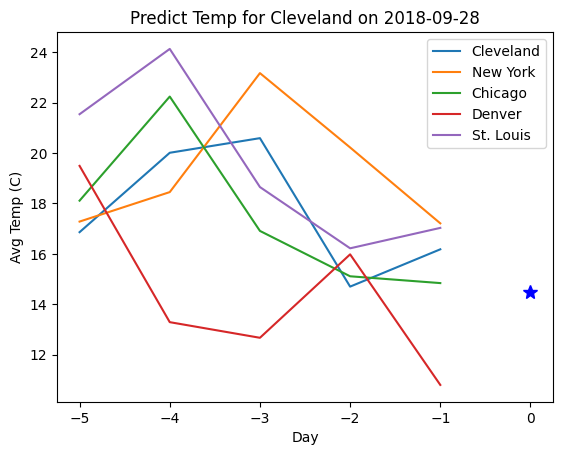

In [210]:
# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[1], y_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



Linear regression test

In [158]:
def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  x2 = x.copy()
  y2 = y.copy()
  for i in np.arange(len(x)):
    x2[i] = x[i] - x[i, fnum]
    y2[i] = y[i] - x[i,fnum]
  return x2, y2

In [173]:
 # linear regression (use Ridge)
from sklearn.linear_model import Ridge
import numpy as np

# original features
# TO DO

lin_regression_original = Ridge(alpha=1)
lin_regression_original.fit(x_train, y_train)
y_pred = lin_regression_original.predict(x_test)


# normalized features
# TO DO

def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  x2 = x.copy()
  y2 = y.copy()
  for i in np.arange(len(x)):
    x2[i] = x[i] - x[i, fnum]
    y2[i] = y[i] - x[i,fnum]
  return x2, y2

fnum = 361

x_train_norm, y_train_norm = normalize_features(x_train, y_train, fnum)
x_test_norm, y_test_norm = normalize_features(x_test, y_test, fnum)

lin_regression_normalized = Ridge(alpha=1)
lin_regression_normalized.fit(x_train_norm, y_train_norm)
y_pred_norm = lin_regression_normalized.predict(x_test_norm)

# Define RMSE calculation function
def calculate_rmse(y_pred, y_true):
    return np.sqrt(np.mean((y_pred-y_true)**2))

rmse_original = calculate_rmse(y_pred, y_test)
rmse_normalized = calculate_rmse(y_pred_norm, y_test_norm)

print(f"RMSE orginal: ", rmse_original)
print(f"RMSE normalized: ", rmse_normalized)

RMSE orginal:  1.7743829555451878
RMSE normalized:  1.7725575696489029


Feature selection

In [160]:

from sklearn import linear_model
from sklearn.linear_model import Ridge


def load_temp_data():
  
  datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW2/Code/temperature_data.npz"
  T = np.load(datadir)
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# feature analysis (select important features using Lasso)
# TO DO

lasso = linear_model.Lasso(alpha = 0.01).fit(x_train, y_train)
optimal_features = []
imp_features = lasso.coef_

for i in range(len(imp_features)):
    if abs(imp_features[i]) > 0.001:
        optimal_features.append((abs(imp_features[i]),i))

features_10 = sorted(optimal_features, reverse=True)[:10]
features_10_idx = []

for i in features_10:
    features_10_idx.append(i[1])

    print("Feature: {} City: {} Day: {}".format(i[1], feature_to_city[i[1]], feature_to_day[i[1]]))


# predict using best features
# TO DO

x_train_10 = x_train[:, features_10_idx]
x_test_10 = x_test[:, features_10_idx]

ridge = linear_model.Ridge(alpha = 0.01).fit(x_train_10, y_train)
y_pred_10 = ridge.predict(x_test_10)

rmse_features = np.sqrt(np.mean((y_pred_10-y_test)**2))

print("RMSE: {}".format(rmse_features))




Feature: 332 City: New York Day: -1
Feature: 361 City: Cleveland Day: -1
Feature: 348 City: Tampa Day: -1
Feature: 412 City: New Haven Day: -1
Feature: 350 City: Brooklyn Day: -1
Feature: 334 City: Chicago Day: -1
Feature: 345 City: Detroit Day: -1
Feature: 405 City: Grand Rapids Day: -1
Feature: 347 City: Minneapolis Day: -1
Feature: 314 City: Fresno Day: -2
RMSE: 2.3531757895767713


/opt/homebrew/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.727e+03, tolerance: 2.049e+01
  model = cd_fast.enet_coordinate_descent(


## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

4a: PR and ROC curves:

4c: Other embeddings

/opt/homebrew/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


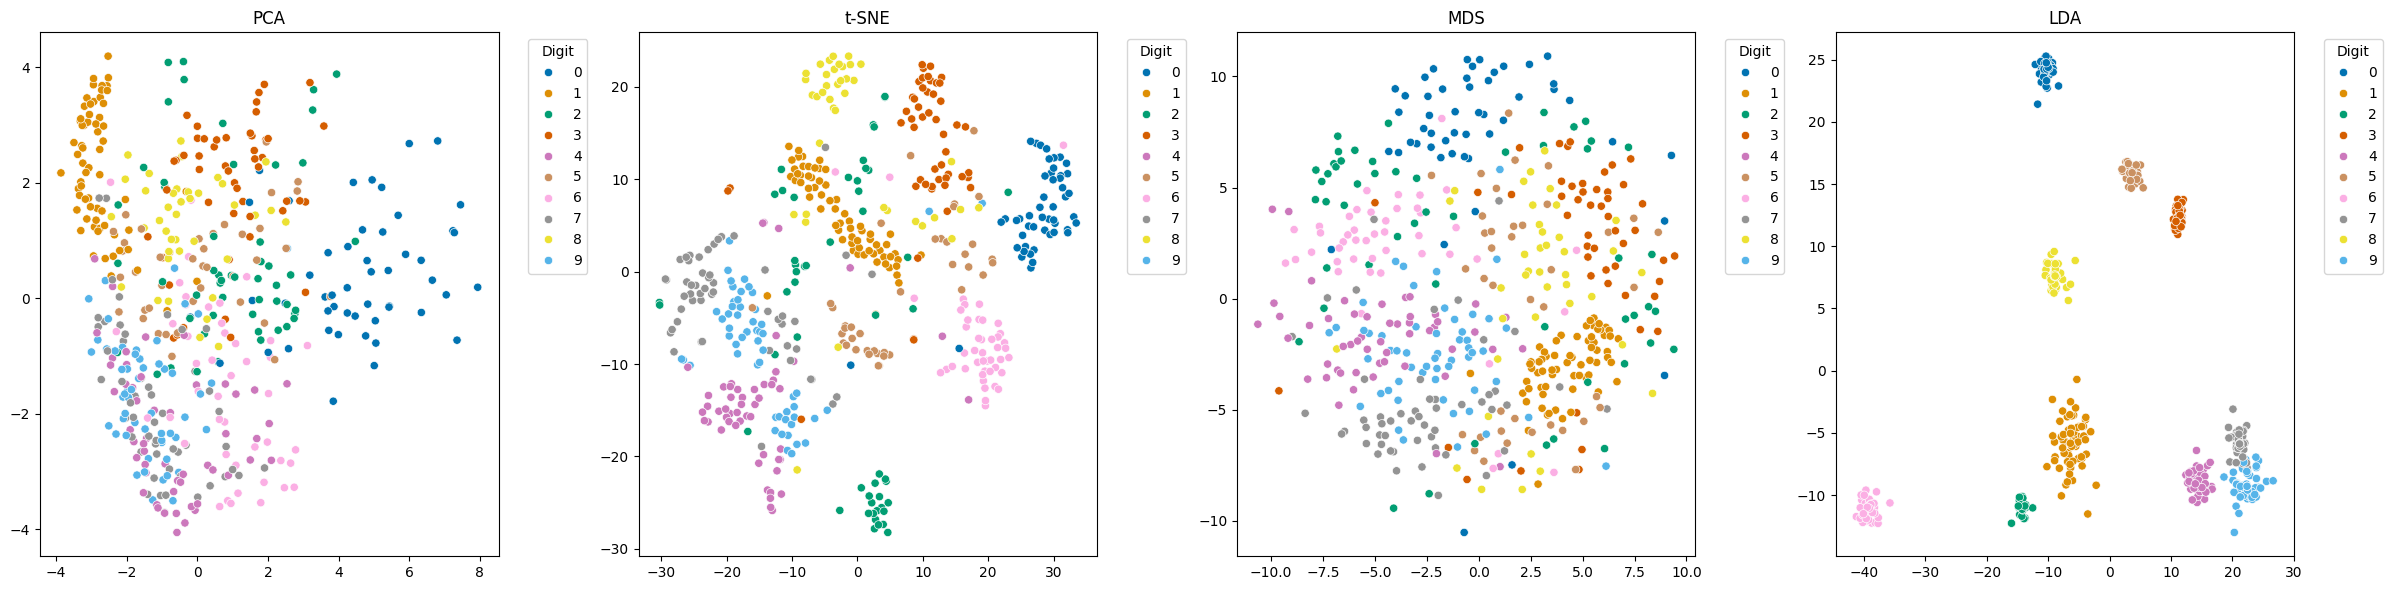

In [167]:
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

(x_train, y_train), (x_test, y_test) = load_mnist()

x_compressed = x_train[:500]
y_compressed = y_train[:500]

# PCA transformation
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_compressed)

# t-SNE transformation
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x_compressed)

# MDS transformation
mds = MDS(n_components=2, random_state=42)
x_mds = mds.fit_transform(x_compressed)

# LDA transformation
lda = LDA(n_components=2)
x_lda = lda.fit_transform(x_compressed, y_compressed)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
plot_labels = ['PCA', 't-SNE', 'MDS', 'LDA']

for i, (x_transformed, title) in enumerate(zip([x_pca, x_tsne, x_mds, x_lda], plot_labels)):
    sns.scatterplot(ax=axes[i], x=x_transformed[:,0], y=x_transformed[:,1], hue=y_compressed, palette="colorblind", legend="full")
    axes[i].set_title(title)
    axes[i].legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


4d. Best city for temp prediction

In [212]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def load_temp_data():
  
  datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW2/Code/temperature_data.npz"
  T = np.load(datadir)
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# Load the data
x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = load_temp_data()

def evaluate_city(city_index):
    # Select data for the specified city
    x_train_city = x_train[:, city_index].reshape(-1, 1)
    x_val_city = x_val[:, city_index].reshape(-1, 1)
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(x_train_city, y_train)
    
    # Predict on the validation set
    y_val_pred = model.predict(x_val_city)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    return rmse

# Dictionary to hold city names and their corresponding RMSE values
city_rmse = {}

# Iterate over all cities (assuming one feature per city)
for city_index in range(x_train.shape[1]):
    rmse = evaluate_city(city_index)
    city_name = feature_to_city[city_index]  # Assuming feature_to_city is a list mapping feature indices to city names
    city_rmse[city_name] = rmse

# Sort cities by RMSE and print the results
sorted_cities_by_rmse = sorted(city_rmse.items(), key=lambda item: item[1])

print("Cities and their RMSE on validation data:")
for city, rmse in sorted_cities_by_rmse:
    print(f"{city}: {rmse:.4f}")





Cities and their RMSE on validation data:
Chicago: 2.8442
St. Louis: 2.8659
Indianapolis: 2.9853
Grand Rapids: 3.1193
Milwaukee: 3.1711
Detroit: 3.3436
Kansas City: 3.4068
Cleveland: 3.4079
Dayton: 3.4296
Cincinnati: 3.4822
Louisville: 3.5352
Tulsa: 3.6153
Akron: 3.6754
Minneapolis: 3.6967
Columbus: 3.7233
Memphis: 3.7251
Nashville: 3.8208
Oklahoma City: 3.8307
Omaha: 3.9372
Buffalo: 3.9613
Dallas: 4.1461
Pittsburgh: 4.1886
Fort Worth: 4.2271
Rochester: 4.3033
Knoxville: 4.3504
Austin: 4.4012
San Antonio: 4.4939
Birmingham: 4.5117
Manhattan: 4.5320
New York: 4.5342
Brooklyn: 4.5348
Bronx: 4.5359
Queens: 4.5470
Baltimore: 4.5659
Bridgeport: 4.5908
New Orleans: 4.5965
New Haven: 4.6441
Albany: 4.6873
Allentown: 4.6877
Houston: 4.6955
Philadelphia: 4.7579
Washington: 4.7773
Springfield: 4.7908
Atlanta: 4.8338
Hartford: 4.8475
Baton Rouge: 4.9067
Boston: 4.9734
Providence: 4.9836
Virginia Beach: 5.0083
Colorado Springs: 5.0569
Charlotte: 5.1007
El Paso: 5.2057
Albuquerque: 5.2148
Richmond:

In [207]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def load_temp_data():
    # Placeholder for the actual load_temp_data function
    pass

def train_and_evaluate_city(x_train, y_train, x_test, y_test, feature_to_city, city_name):
    """
    Trains a Linear Regression model for a specific city's temperature data and evaluates it on the test set.

    Parameters:
    - x_train: Training feature data
    - y_train: Training target data
    - x_test: Test feature data
    - y_test: Test target data
    - feature_to_city: List mapping feature indices to city names
    - city_name: The name of the city to evaluate

    Returns:
    - rmse_test: The RMSE of the model on the test set for the specified city
    """
    # Load the data
    x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = load_temp_data()
    
    # Find the index for the specified city
    try:
        index = feature_to_city.index(city_name)
    except ValueError:
        print(f"{city_name} not found in the feature_to_city mapping.")
        return
    
    # Select the temperature data for the specified city
    x_train_city = x_train[:, index].reshape(-1, 1)
    x_test_city = x_test[:, index].reshape(-1, 1)
    
    # Train a Linear Regression model on the training data for the city
    model = LinearRegression()
    model.fit(x_train_city, y_train)
    
    # Predict the temperature on the test set
    y_test_pred = model.predict(x_test_city)
    
    # Calculate the RMSE on the test set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print(f"Test RMSE for {city_name}: {rmse_test:.4f}")
    return rmse_test

# Example usage
# Assuming the load_temp_data function is defined elsewhere and loads your dataset correctly
# rmse_test_st_louis = train_and_evaluate_city(x_train, y_train, x_test, y_test, feature_to_city, 'St. Louis')


4e. SVM with RBF Kernel

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import numpy as np

(x_train, y_train), (x_test, y_test) = load_mnist()

nsample = [100, 1000, 10000, 60000]
results_lin = []
results_rbf = []

for N in nsample:
    x_train_N = x_train[:N]
    y_train_N = y_train[:N]
    
    # Train Linear SVM
    svm = LinearSVC(max_iter=10000)
    svm.fit(x_train_N, y_train_N)
    y_pred_svm = svm.predict(x_test)
    error_svm = 1 - accuracy_score(y_test, y_pred_svm)

    # Train RBF SVM
    svm_rbf = SVC(max_iter=10000, kernel="rbf")
    svm_rbf.fit(x_train_N, y_train_N)
    y_pred_svm_rbf = svm_rbf.predict(x_test)
    error_svm_rbf = 1 - accuracy_score(y_test, y_pred_svm_rbf)
    
    # Store the results
    results_lin.append({
        'Training Size': N,
        'Linear SVM Error': error_svm
    })

    results_rbf.append({
        'Training Size': N,
        'RBF SVM Error': error_svm_rbf
    })

# Display the results
for result in results_lin:
    print(f"Training Size: {result['Training Size']}, Linear SVM Error: {result['Linear SVM Error']:.4f}")

for result in results_rbf:
    print(f"Training Size: {result['Training Size']}, RBF SVM Error: {result['RBF SVM Error']:.4f}")    


/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Size: 100, Linear SVM Error: 0.3235
Training Size: 1000, Linear SVM Error: 0.1611
Training Size: 10000, Linear SVM Error: 0.1112
Training Size: 60000, Linear SVM Error: 0.0817
Training Size: 100, RBF SVM Error: 0.3441
Training Size: 1000, RBF SVM Error: 0.0917
Training Size: 10000, RBF SVM Error: 0.0406
Training Size: 60000, RBF SVM Error: 0.0208


In [122]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

ModuleNotFoundError: No module named 'google.colab'